# AB diblock copolymers in Potential Fields

This example script demonstrates how to compute single partition functions and concentrations of AB diblock copolymers for given potential fields.

### 1. Import python modules and set environment variables

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

### 2. Setup some simulation parameters

\begin{align}
L_x &= 5.0 bN^{1/2} \\
L_y &= 5.0 bN^{1/2} \\
V &= L_x L_y \\ 
m_x &= 64 \\
m_y &= 64 \\
b_A/b_{ref} &= 1.0 \\
b_B/b_{ref} &= 1.0 \\  
\Delta s &= 0.01
\end{align}

In [47]:
# Simulation parameters
nx = [64,64]                       # grid number
lx = [5.0,5.0]                     # box size
stat_seg_lengths = {"A":1.0,       # statistical segment lengths
                    "B":1.0}        

ds = 0.01                          # contour step interval

### 3. Create a factory with chosen platform ("cuda" or "cpu-mkl") and data-type ("real", "complex")
* The factory will create the following instances for chosen platform and data-type.
    * simulation_box
    * molecules
    * propagator_computation_optimizer
    * solver

In [3]:
# Select platform ("cuda" or "cpu-mkl") for real-valued simulations
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cuda", reduce_gpu_memory_usage, "real")
factory.display_info()

========== CUDA Setting and Device Information ==========
N_BLOCKS, N_THREADS: 256, 256
DeviceCount (# of available GPUs): 4
Device 0: 				NVIDIA A10
Compute capability version: 		8.6
Multiprocessor: 			72
Global memory: 				22502 MBytes
Constant memory: 			65536 Bytes
Shared memory per block: 		49152 Bytes
Registers available per block: 		65536
Warp size: 				32
Maximum threads per block: 		1024
Max size of a thread block (x,y,z): 	(1024, 1024, 64)
Max size of a grid size    (x,y,z): 	(2147483647, 65535, 65535)
Device overlap: 			Yes


In [4]:
# Create an instance for computation box
cb = factory.create_computation_box(nx, lx) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

### 4. Add AB diblock copolymers in molecules with $f_A = 0.7$ and $f_B = 0.3$
In the graph notation, there are three junctions, [0, 1, 2], and there are two blocks, [[0, 1], [2, 3]].

In [5]:
# Add AB diblock copolymers
volume_fraction = 1.0
blocks = [["A", 0.7, 0, 1],   # monomer type, statistical segment length, start index, end index
          ["B", 0.3, 1, 2]]
molecules.add_polymer(volume_fraction, blocks)

### 5. Analyze graphs and optimize the computations.

Remove the redundent computations and aggregate propagators of multiple side chains. To understand the internal algorithm, read the following paper.

[Dynamic Programming for Chain Propagator Computation of Branched Block Copolymers in Polymer Field Theory Simulations](https://doi.org/10.1021/acs.jctc.5c00103)

In [6]:
# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, A:
	 X, (X, O), (70, 70), (B30)A, 1, {0,1}

0, B:
	 X, (X, O), (30, 30), (A70)B, 1, {2,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
B:
	 0, X, 30, 0, {30}, 
A:
	 0, X, 70, 0, {70}, 
(B30)A:
	 1, X, 70, 1, {}, 
(A70)B:
	 1, X, 30, 1, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 200
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 0 %


### 5. Set Potential fields

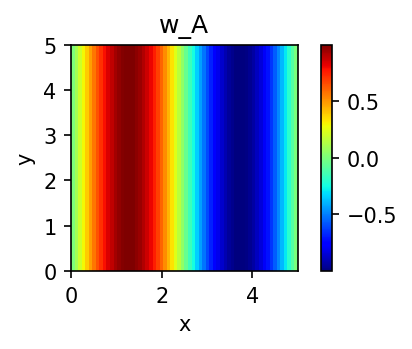

In [102]:
w_A =  np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for A
w_B = -np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for B
w = {"A": w_A, "B": w_B}  # potential field dictionary

plt.figure(figsize=(4, 2))
plt.title('w_A')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(w_A, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet)  # , interpolation='nearest',
plt.colorbar()
plt.show()

### 6. Solving the modified diffusion equations and compute single chain partition function

The foward propagators:
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_A^2}{6}\nabla^2 - w_A({\bf r})\right] q^{0 \rightarrow 1}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, f_A] \\
\left[-\frac{\partial}{\partial s} + \frac{b_B^2}{6}\nabla^2 - w_B({\bf r})\right] q^{1 \rightarrow 2}_0({\bf r}, s)=0,\ \ \ \ \ s\in [f_A, 1] \\
\end{align}

The backword propagators:
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_B^2}{6}\nabla^2 - w_B({\bf r})\right] q^{2 \rightarrow 1}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, f_B] \\
\left[-\frac{\partial}{\partial s} + \frac{b_A^2}{6}\nabla^2 - w_A({\bf r})\right] q^{1 \rightarrow 0}_0({\bf r}, s)=0,\ \ \ \ \ s\in [f_B, 1] \\
\end{align}

Single chain partition function:
\begin{align}
Q_0 = \frac{1}{V}\int d{\bf r}\ q^{0 \rightarrow 1}_0({\bf r}, s)q^{1 \rightarrow 0}_0({\bf r}, f_A-s) 
\end{align}

In [8]:
# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

# Compute Propagators (q) and single partition function (Q)
solver.compute_propagators({"A":w["A"], "B":w["B"]})

# Single partition function
Q = solver.get_total_partition(0)
print(f"Q:", Q)

Q: 1.0448485262424192


### 7. Compute concentrations

\begin{align}
\phi_A({\bf r}) &= \frac{1}{Q}\int_{0}^{f_A} ds\ q^{0 \rightarrow 1}_0({\bf r}, s)q^{1 \rightarrow 0}_0({\bf r}, f_A-s) \\
\phi_B({\bf r}) &= \frac{1}{Q}\int_{0}^{f_B} ds\ q^{1 \rightarrow 2}_0({\bf r}, s)q^{2 \rightarrow 1}_0({\bf r}, f_B-s) 
\end{align}

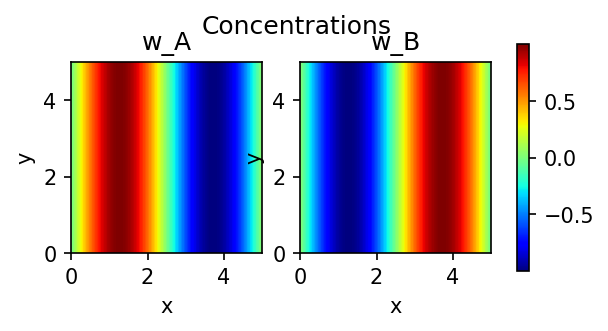

In [78]:
# Compute ensemble average concentration (phi)
solver.compute_concentrations()

# Get the ensemble average concentration for each monomer type
phi_a = solver.get_total_concentration("A")
phi_b = solver.get_total_concentration("B")

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
fig.suptitle("Concentrations")
im = axes[0].imshow(w_A, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet)
im = axes[1].imshow(w_B, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet)
axes[0].set(title='w_A', xlabel='x', ylabel='y')
axes[1].set(title='w_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 8. Access the propagators

In [131]:
import matplotlib.animation as animation
from IPython.display import HTML

p,v,u=(0, 0, 1)

# Create an animation of the chain propagator
fig, ax = plt.subplots(figsize=(4, 2))
im = ax.imshow(np.reshape(solver.get_chain_propagator(p, v, u, 0), nx), extent=(0, lx[0], 0, lx[1]), cmap='viridis', vmin=0, vmax=2)
fig.colorbar(im, ax=ax)
def update(frame):
    im.set_array(np.reshape(solver.get_chain_propagator(p, v, u, frame), nx))
    return [im]
anim = animation.FuncAnimation(fig, update, frames=70, interval=1, repeat=False)

# Close the static figure to prevent it from displaying
plt.close(fig)

# Display only the animation
HTML(anim.to_jshtml())